## Sales Forecasting:
Sales forecasting is a process which enables a business to predict future sales.
Here,we have to predict sales of a particular Product given from a ProductClass and ProductLine it belongs and Region from where it was sold.
we have following features :
## 1.ABCIndicator:
Procedure for determining the importance of an object; it is used to classify objects according to specific criteria or key figures.

It allows you to put the objects into common groupings by dividing them into the following areas:

A: Important
B: Less important
C: Relatively unimportant
ABC analysis is used in SAP NetWeaver Business Intelligence.
## 2.Month:
month on which it is sold.
## 3.ProductClassDesc:
It is the category from which a product belongs to.
## 4.ProductLineDesc:
It is the subcategory of product class.
## 5.SalesDistrictDesc
It is the region to which product is sold.
## 6.Shippable_$
Total revenue generated from the product for a particular month.
## 7. Year
year on which product is sold.



In [153]:
#Import required Libraries
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import statsmodels
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm #For Dickey-Fuller Test
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
rcParams['figure.figsize'] = 15, 6

In [154]:
#Reading a csv file
df=pd.read_csv('shippable_revenue_forecasting.csv')
df.head()

,ABCIndicator,Month,ProductClassDesc,ProductLineDesc,SalesDistrictDesc,Shippable_$,Year
0,P,1,Underground,Enclosures & Drains,West Region,590.05,2017
1,P,1,Fiberglass Construction,Safety Products,Communication - West,0.00,2017
2,C,1,Fiberglass Construction,Safety Products,Communication - West,0.00,2017
3,A,1,Fiberglass Construction,Safety Products,Communication - West,435.77,2017
4,B,1,Fiberglass Construction,Safety Products,Communication - East,0.00,2017


In [155]:
df.columns

Index(['ABCIndicator', 'Month', 'ProductClassDesc', 'ProductLineDesc',
       'SalesDistrictDesc', 'Shippable_$', 'Year'],
      dtype='object')

In [156]:
train=df[1:round(len(df)*0.9)]  #here we can't use random train test split because this is time series data ,so we need values sequentially
train.shape

(31593, 7)

In [157]:
test=df[31593:]
test.shape

(3511, 7)

In [158]:
#Making a copy, to protect original data
train_original = train.copy()
test_original =test.copy()

In [143]:
# #we need to aggregate this data as this have subcategories also.
# g1=train.groupby(['Year','Month','SalesDistrictDesc','ProductLineDesc','ProductClassDesc'])['Shippable_$'].sum()
# g2=pd.DataFrame(g1.reset_index(name = "Shippable_$"))
# arrester_values=g2[g2['ProductLineDesc']=='Arresters']['Shippable_$']

# Hypothesis Generation
1.Shippable(revenue) is dependent on time.

2.It is possible that a particular product generate more revenue in a particular month.

3.ABCIndicator indicates a state , so it is possible that shippable will depend on it.

4.More shippable from a particular product line. 


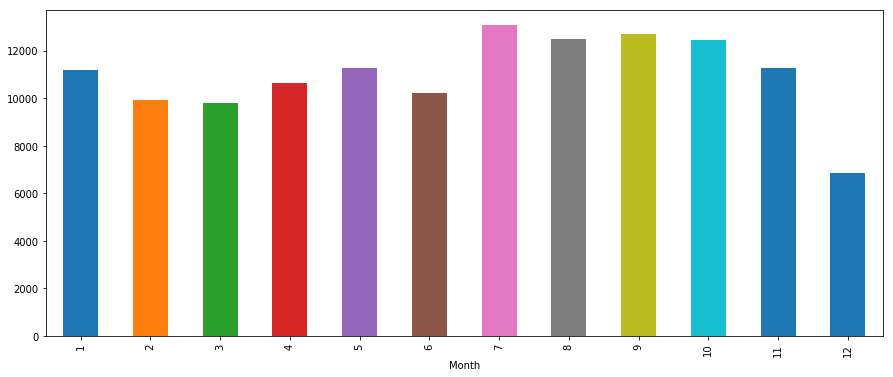

In [144]:
train.groupby('Month')['Shippable_$'].mean().plot.bar()

We can't infer anything from this graph as it is not showing any pattern.Let's make it time series and try it in another way

In [159]:
train=train.loc[train.ProductClassDesc!='#'] #Removing # values
test = test.loc[test.ProductClassDesc!='#'] 

In [160]:
train.isnull().sum()# No Missing Values

ABCIndicator         0
Month                0
ProductClassDesc     0
ProductLineDesc      0
SalesDistrictDesc    0
Shippable_$          0
Year                 0
dtype: int64

In [161]:
train.head()# Need to combine Year and Month to make this data ,datatime data.

,ABCIndicator,Month,ProductClassDesc,ProductLineDesc,SalesDistrictDesc,Shippable_$,Year
1,P,1,Fiberglass Construction,Safety Products,Communication - West,0.00,2017
2,C,1,Fiberglass Construction,Safety Products,Communication - West,0.00,2017
3,A,1,Fiberglass Construction,Safety Products,Communication - West,435.77,2017
4,B,1,Fiberglass Construction,Safety Products,Communication - East,0.00,2017
5,A,1,Fiberglass Construction,Safety Products,Communication - East,1055.10,2017


In [165]:
def combine(a,b):
    date=str(a)+"-"+str(b)
    return date

train['Date']=train[['Month','Year']].apply(lambda x:combine(x.Month,x.Year),axis=1)
test['Date']=test[['Month','Year']].apply(lambda x:combine(x.Month,x.Year),axis=1)
dateparse = lambda Dates: pd.datetime.strptime(Dates, '%m-%Y')

In [166]:
train.head()

,ABCIndicator,Month,ProductClassDesc,ProductLineDesc,SalesDistrictDesc,Shippable_$,Year,Date
1,P,1,Fiberglass Construction,Safety Products,Communication - West,0.00,2017,1-2017
2,C,1,Fiberglass Construction,Safety Products,Communication - West,0.00,2017,1-2017
3,A,1,Fiberglass Construction,Safety Products,Communication - West,435.77,2017,1-2017
4,B,1,Fiberglass Construction,Safety Products,Communication - East,0.00,2017,1-2017
5,A,1,Fiberglass Construction,Safety Products,Communication - East,1055.10,2017,1-2017


In [167]:
train['Date']=train['Date'].apply(lambda x:dateparse(x))
test['Date'] =test['Date'].apply(lambda x:dateparse(x))

In [168]:
train.head()# Now we have a Datetime column date, we can remove Month and Year column

,ABCIndicator,Month,ProductClassDesc,ProductLineDesc,SalesDistrictDesc,Shippable_$,Year,Date
1,P,1,Fiberglass Construction,Safety Products,Communication - West,0.00,2017,2017-01-01
2,C,1,Fiberglass Construction,Safety Products,Communication - West,0.00,2017,2017-01-01
3,A,1,Fiberglass Construction,Safety Products,Communication - West,435.77,2017,2017-01-01
4,B,1,Fiberglass Construction,Safety Products,Communication - East,0.00,2017,2017-01-01
5,A,1,Fiberglass Construction,Safety Products,Communication - East,1055.10,2017,2017-01-01


In [169]:
train.index=train['Date'] #Making Date column as index column
test.index=test['Date']

In [170]:
train.head() #Now we have our DateTime data ready for analysis.

,ABCIndicator,Month,ProductClassDesc,ProductLineDesc,SalesDistrictDesc,Shippable_$,Year,Date
Date,,,,,,,,
2017-01-01,P,1,Fiberglass Construction,Safety Products,Communication - West,0.00,2017,2017-01-01
2017-01-01,C,1,Fiberglass Construction,Safety Products,Communication - West,0.00,2017,2017-01-01
2017-01-01,A,1,Fiberglass Construction,Safety Products,Communication - West,435.77,2017,2017-01-01
2017-01-01,B,1,Fiberglass Construction,Safety Products,Communication - East,0.00,2017,2017-01-01
2017-01-01,A,1,Fiberglass Construction,Safety Products,Communication - East,1055.10,2017,2017-01-01


In [180]:
train.ProductLineDesc.value_counts()

Safety Products        5233
Switching & Fusing     4997
Connectors             3756
Utility Automation     3685
Arresters              3301
Construction           3111
Enclosures & Drains    2554
Insulators             1661
Bushings               1616
Cable Accessories      1511
Wire Management           6
Name: ProductLineDesc, dtype: int64

In [190]:
#FOR YEAR 2017 AND CATEGORY ARRESTERS
ts=train[(train['Year']==2017) &(train['ProductLineDesc']=='Arresters')]
ts.ProductClassDesc.value_counts()

Distribution Arresters     500
Substation SC Arresters    456
Substation HC Arresters    369
Transmission Arresters     192
Blocks                      30
Name: ProductClassDesc, dtype: int64

In [196]:
ts.groupby('ProductClassDesc')['Shippable_$'].count()

ProductClassDesc
Blocks                      30
Distribution Arresters     500
Substation HC Arresters    369
Substation SC Arresters    456
Transmission Arresters     192
Name: Shippable_$, dtype: int64

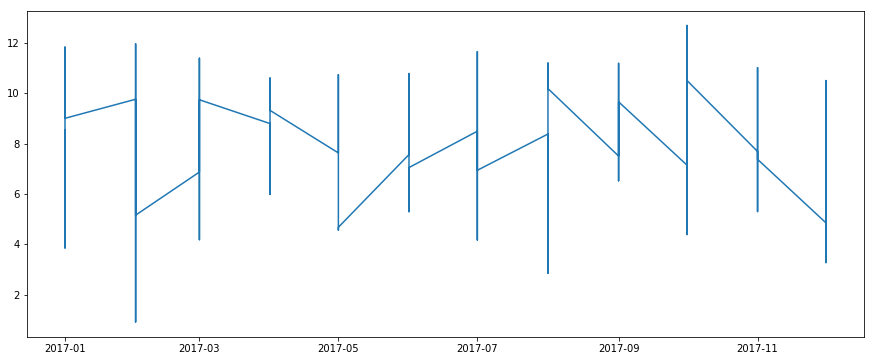

In [230]:
DA=ts[ts['ProductClassDesc']=='Distribution Arresters']
DA=DA[DA['Shippable_$']!=0]
DA['Shippable_$']=np.log(DA['Shippable_$']+1)
plt.plot(DA['Shippable_$'])

In [ ]:
ts=train['Shippable_$']
plt.figure(figsize=(16,8))
plt.plot(ts,label="Shippable")
plt.title('Time Series')
plt.xlabel("Time(year-month)")
plt.ylabel("Shippable")
plt.legend(loc="best")

we still can't infer anything from the above graph,now we try to plot it for a particular product line

In [ ]:
#Now we will aggregate data and then try to find patterns.
g1=train.groupby(['SalesDistrictDesc','Year','Month','ProductLineDesc','ProductClassDesc']).sum()
g1=g1.reset_index()

In [ ]:
def combine(a,b):
    date=str(a)+"-"+str(b)
    return date

g1['Date']=g1[['Month','Year']].apply(lambda x:combine(x.Month,x.Year),axis=1)
# test['Date']=test[['Month','Year']].apply(lambda x:combine(x.Month,x.Year),axis=1)
dateparse = lambda Dates: pd.datetime.strptime(Dates, '%m-%Y')
g1['Date']=g1['Date'].apply(lambda x:dateparse(x))

In [ ]:
g1.index=g1.Date

In [ ]:
arrester_value=g1.loc[(g1['ProductLineDesc']=='Arresters') & (g1['ProductClassDesc']=='Distribution Arresters')]
ts=arrester_value['Shippable_$']
plt.plot(ts)

In [ ]:
#Now let's try to validate our 3 hypothesis about ABCindicator
train.groupby('ABCIndicator')['Shippable_$'].mean().plot.bar()

Most of the products belong from A,B,C category..

In [ ]:
# Now Lets try to predict on test data. But for that let's convert our features into numeric datatype
labelencoder = LabelEncoder()
train['ProductClassDesc']=labelencoder.fit_transform(train['ProductClassDesc'])
train['SalesDistrictDesc']=labelencoder.fit_transform(train['SalesDistrictDesc'])
train['ABCIndicator'] =labelencoder.fit_transform(train['ABCIndicator'])

In [ ]:
dummies=pd.get_dummies(train['ProductLineDesc'])

In [ ]:
train=pd.concat([train, dummies], axis=1)

In [ ]:
del train['ProductLineDesc']

In [ ]:
train.head()# Now All columns are numerical

## Augmented Dickey-Fuller Test (ADF) Statistical Test
To determine if a time series is stationary or not, we will use the ADF test which is a type of unit root test. Unit roots are a cause for non-stationarity, the ADF test will test if unit root is present.



A time series is stationary if a single shift in time doesn't change the time series statistical properties, in which case unit root does not exist.

The Null and Alternate hypothesis of the Augmented Dickey-Fuller test are defined as follows:

Null Hypothesis states there is presence of a unit root.
Alternate Hypothesis states there is no unit root. In other words, Stationarity exists.

In [ ]:
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
        
    def ADF_Stationarity_Test(self, timeseries, printResults = True):

        #Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC')
        
        self.pValue = adfTest[1]
        
        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])

            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value

            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)

In [ ]:
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(train['Shippable_$'], printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

## Hence our DATA is stationary as P- value is less than 0.5.

In [ ]:
# model1=sm.tsa.ARIMA(endog=train['Shippable_$'],exog=df1[['ABCIndicator', 'ProductClassDesc', 'SalesDistrictDesc',
#        'Arresters', 'Bushings', 'Cable Accessories', 'Connectors',
#        'Construction', 'Enclosures & Drains', 'Insulators', 'Safety Products',
#        'Switching & Fusing', 'Utility Automation', 'Wire Management']],order=[1,0,0])
# results1=model1.fit()
# print(results1.summary())

In [214]:
g2=pd.read_csv('Sales_forecasting.csv')

In [217]:
df.head()

,ABCIndicator,Month,ProductClassDesc,ProductLineDesc,SalesDistrictDesc,Shippable_$,Year
0,P,1,Underground,Enclosures & Drains,West Region,590.05,2017
1,P,1,Fiberglass Construction,Safety Products,Communication - West,0.00,2017
2,C,1,Fiberglass Construction,Safety Products,Communication - West,0.00,2017
3,A,1,Fiberglass Construction,Safety Products,Communication - West,435.77,2017
4,B,1,Fiberglass Construction,Safety Products,Communication - East,0.00,2017


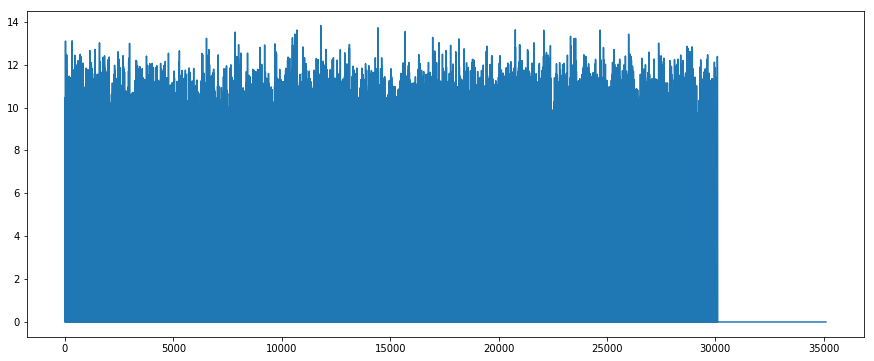